In [24]:
#importing libraries
import random
from IPython.display import clear_output, display
import time
import chess
import numpy as np
import itertools

In [2]:
#Defining the Node
class Node:
    def __init__(self, move, value, parent=None):
        self.move = move
        self.value = value
        self.parent = parent
        self.children = list()
    

In [39]:
#Defining constants
pawn_value = 100
knight_value = 300
bishop_value = 300
rook_value = 500
queen_value = 900

piece_value_map = {
    chess.PAWN: 100,
    chess.KNIGHT: 300,
    chess.BISHOP: 300,
    chess.ROOK: 500,
    chess.QUEEN: 900,
    chess.KING: 1000
}

In [40]:
def cal_material(observation, turn):
    total = 0
    
    #number of pawns
    total += len(observation.pieces(chess.PAWN, turn)) * piece_value_map[chess.PAWN]
    #number of white knights
    total += len(observation.pieces(chess.KNIGHT, turn)) * piece_value_map[chess.KNIGHT]
    #number of bishops
    total += len(observation.pieces(chess.BISHOP, turn)) * piece_value_map[chess.BISHOP]
    #number of rooks 
    total += len(observation.pieces(chess.ROOK, turn)) * piece_value_map[chess.ROOK]
    #number of queens
    total += len(observation.pieces(chess.QUEEN, turn)) * piece_value_map[chess.QUEEN]
    
    return total


#function to evaluate the board
def evaluate_board(observation):
    #get sum of both sides points
    white_eval = cal_material(observation, chess.WHITE)
    black_eval = cal_material(observation, chess.BLACK)
    
    #Negative board value means black is leading, positive means white
    evaluation = white_eval - black_eval
    
    #if it is black's turn flip the sign so that better is positive instead of negative
    perspective = 1
    if not observation.turn: 
        perspective *= -1 
    
    return evaluation*perspective

    #end result will be:
        #if it is white's turn, positive is better negative is better
        #if it is black's turn, positive is better and negative is better
    
#Search Function
def search(observation, depth, alpha, beta):
    
    if depth == 0:
        return search_all_captures(observation, alpha, beta)
    if observation.is_checkmate():
        return -1e9
    if observation.is_stalemate():
        return 0
    
    moves = list(observation.legal_moves)
    moves.sort(key= lambda x: eval_move(observation, x))
    
    best_eval = -1e9
    
    for x in moves:
        observation.push(x)
        evaluation = -search(observation, depth-1, -beta, -alpha)
        observation.pop()
        if evaluation >= beta:
            return beta
        alpha = max(alpha, evaluation)
        
    return alpha

def eval_move(board, move):
    move_score = 0
    move_piece = board.piece_type_at(move.from_square)
    capture_piece = board.piece_type_at(move.to_square)
    
    if board.is_capture(move):
        move_score = 10 * piece_value_map[capture_piece] - piece_value_map[move_piece]
    
    if move.promotion:
        move_score += piece_value_map[move.promotion]
    
    pawn_squares = [x for x in chess.SQUARES if board.piece_type_at(x) == chess.PAWN]
    attacked_by_pawns = list(itertools.chain.from_iterable(map(board.attacks, pawn_squares)))
    if move.to_square in attacked_by_pawns:
        move_score -= piece_value_map[move_piece]
    
    return move_score
    
def search_all_captures(observation, alpha, beta):
        evaluation = evaluate_board(observation)

        if evaluation >= beta:
            return beta
        alpha = max(alpha, evaluation)

        capture_moves = [x for x in observation.legal_moves if observation.is_capture(x)]

        for move in capture_moves: 

            observation.push(move)
            evaluation = -search_all_captures(observation, -beta, -alpha)
            observation.pop()

            if evaluation >= beta:
                return beta
            alpha = max(alpha, evaluation)

        return alpha

In [ ]:
class AlphaBetaAgent:
    
    def alpha_beta_search(self, board, search_depth):
        evaluations = list()
        for move in board.legal_moves:
            board.push(move)
            evaluations.append((move, search(board, search_depth-1, -1e9, 1e9)))
            board.pop()
        return max(evaluations, key=lambda x: x[1])[0]
        

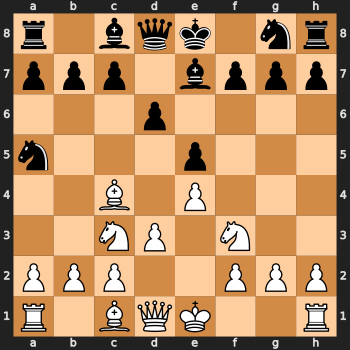

'True'

KeyboardInterrupt: 

In [47]:
import chess.svg
import cProfile
import pstats

SCENARIO_1 = '4k3/4P3/3PK3/8/8/8/8/8 w - - 0 1'
SCENARIO_2 = '8/3k4/8/8/8/3K4/3R4/3R4 w - - 0 1'
SCENARIO_3 = 'r1bqk1nr/ppp1bppp/3p4/n3p3/2B1P3/2NP1N2/PPP2PPP/R1BQK2R w KQkq - 1 6'

agent = AlphaBetaAgent()
board = chess.Board(SCENARIO_3)

time_to_move = list()

with cProfile.Profile() as pr:
    while not board.is_game_over():
        clear_output(wait=True)
        display(chess.svg.board(board, size=350))
        display(f'{board.turn}')
        if board.turn:
            start = time.perf_counter()
            action = agent.alpha_beta_search(board.copy(stack=False), 3)
            time_to_move.append(time.perf_counter() - start)
        else:
            action = random.choice(list(board.legal_moves))
        board.push(action)

display(chess.svg.board(board, size=350))
board.outcome()

In [31]:
pawn_squares = [x for x in chess.SQUARES if board.piece_type_at(x) == chess.PAWN]
attacked_by_pawns = list(itertools.chain.from_iterable(map(board.attacks, pawn_squares)))
attacked_by_pawns

[17,
 16,
 18,
 17,
 19,
 20,
 22,
 21,
 23,
 22,
 26,
 28,
 35,
 37,
 27,
 29,
 34,
 36,
 41,
 40,
 42,
 41,
 43,
 44,
 46,
 45,
 47,
 46]

In [45]:
stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

         128190253 function calls (127875481 primitive calls) in 53.191 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  6835383    5.750    0.000   15.476    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:1650(generate_pseudo_legal_moves)
  6482822    3.694    0.000    4.561    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:3106(is_capture)
 13922405    3.606    0.000    4.252    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:278(scan_reversed)
  6685384    3.382    0.000    7.309    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:3450(_is_safe)
  6711474    3.125    0.000   27.143    0.000 C:\Users\engli\anaconda3\lib\site-packages\chess\__init__.py:3488(generate_legal_moves)
   225074    2.360    0.000   33.837    0.000 <ipython-input-40-a5fa1adf43c0>:88(<listcomp>)
  1348043    2.188    0.000    2.188    0.000 C:\Users\engli\anaconda3\lib\si